<a href="https://colab.research.google.com/github/chakma21/BTP/blob/main/Exploringlib/generalizationSphK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -U numpy
!pip install -U sentence-transformers pandas openpyxl
# !pip install scikit-learn pandas numpy openpyxl

Saving HW_keybert_keywords.csv to HW_keybert_keywords (2).csv
Sample of keywords: ['york accuses weinstein', 'harvey weinsteins alleged', 'harvey weinstein allegations', 'weinsteins alleged sexual', 'accusations rape weinstein', 'accuses weinstein raping', 'accuses harvey weinsteins', 'weinstein charged rape', 'harvey weinstein accused', 'allegations harvey weinstein']


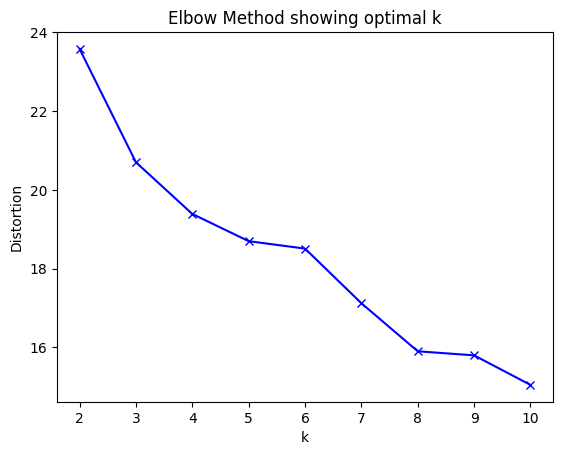


Cluster 'weinsteins alleged misconduct':
9 items:
['weinstein sexual misconduct', 'weinsteins alleged behaviour', 'harvey weinstein misconduct', 'weinsteins alleged misconduct', 'misconduct harvey weinstein', 'sues weinstein alleged', 'weinstein accusers record', 'police investigating weinstein', 'weinstein misconduct']

Cluster 'harvey weinstein sexual':
9 items:
['assaulted harvey weinstein', 'harvey weinstein raped', 'harvey weinstein assault', 'raped harvey weinstein', 'yorker weinstein sexually', 'assaults harvey weinstein', 'harvey weinstein sexual', 'harassment harvey weinstein', 'harvey weinstein inappropriate']

Cluster 'weinstein allegations':
45 items:
['york accuses weinstein', 'weinsteins alleged sexual', 'accusations rape weinstein', 'accuses weinstein raping', 'new allegations weinstein', 'weinstein alleged sexual', 'weinstein allegations', 'sexual allegations weinstein', 'weinstein following allegations', 'allegations weinstein new', 'weinsteins sexual conduct', 'weins

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

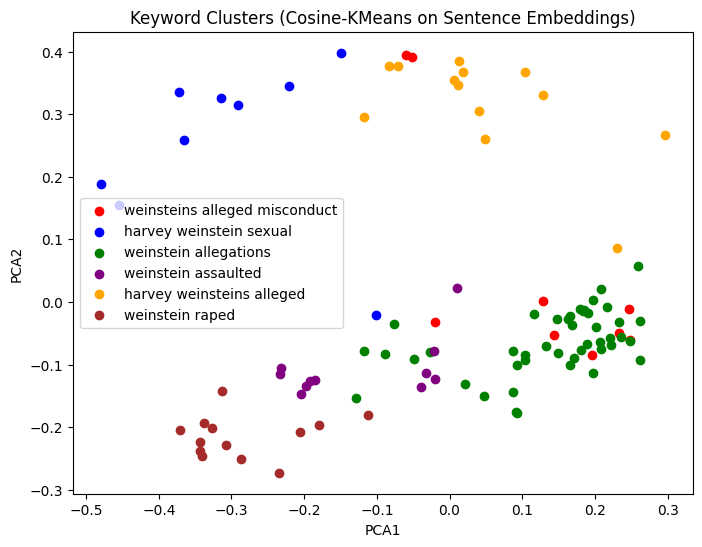

In [8]:

# Imports
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from google.colab import files
import io

# Step 1: Upload CSV with keywords
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 2: Load keywords
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
    keyword_col = [col for col in df.columns if 'keyword' in col.lower()]
    if keyword_col:
        keywords = df[keyword_col[0]].astype(str).tolist()
    else:
        keywords = df.iloc[:,1].astype(str).tolist()
except Exception:
    lines = io.StringIO(uploaded[filename].decode('utf-8')).read().splitlines()
    keywords = [line.split(',')[1] for line in lines if ',' in line]

keywords = [k.strip() for k in keywords if k.strip()]
print("Sample of keywords:", keywords[:10])

# Step 3: Get embeddings and normalize (for cosine-based clustering)
model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(keywords)
X_norm = normalize(X)  # Normalize to unit vectors
# turns your regular KMeans into an approximation of Spherical KMeans, which:
# Clusters based on angular similarity (≈ cosine).

# Step 4: Elbow plot (to choose k)
def plot_elbow(X, max_k=10):
    distortions = []
    K = range(2, max_k+1)
    for k in K:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(X)
        distortions.append(km.inertia_)
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method showing optimal k')
    plt.show()

plot_elbow(X_norm, max_k=10)

# Step 5: Cluster with cosine-based KMeans
k = 6  # adjust if needed
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_norm)

# Step 6: Create cluster dataframe and get representative keywords
clustered = pd.DataFrame({'Keyword': keywords, 'Cluster': labels})
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_norm)
cluster_names = [keywords[idx] for idx in closest]
clustered['Cluster Name'] = clustered['Cluster'].map(lambda x: cluster_names[x])

# Step 7: Print clusters
for i, name in enumerate(cluster_names):
    print(f"\nCluster '{name}':")
    items = clustered[clustered['Cluster'] == i]['Keyword'].tolist()
    print(f"{len(items)} items:")
    print(items)

# Step 8: Export results
excel_filename = "clustered_keywords_cosineKMeans.xlsx"
clustered.to_excel(excel_filename, index=False)
files.download(excel_filename)

# Step 9: PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, name in enumerate(cluster_names):
    idxs = clustered['Cluster'] == i
    plt.scatter(X_pca[idxs,0], X_pca[idxs,1], c=colors[i%len(colors)], label=name)
plt.legend()
plt.title('Keyword Clusters (Cosine-KMeans on Sentence Embeddings)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()
